# Aligning heart ST data from ISS

Serial sections of 6.5 PCW human heart from the Human Cell Atlas https://doi.org/10.1016/j.cell.2019.11.025

In [4]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch


# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [ ]:
# OPTION A: import STalign after pip install
import sys
from STalign import STalign

In [2]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `data_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [35]:
# Single cell data 1
# read in data
fname = '../heart_data/3_CN73_D2.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

   Unnamed: 0             x             y   intensity  area    id    color   
0       23955   8531.077148  15460.102539  133.222229    26   NaN  #000000  \
1       23956  10820.615234  13469.435547  186.047623    52   NaN  #000000   
2       23957  10621.416992  13253.666992  201.217392    32  17.0  #0B61A4   
3       23958  10583.570312  13248.559570  192.793106    62  17.0  #0B61A4   
4       23959  10541.403320  13236.280273  190.444443    38  17.0  #0B61A4   

  acronym  right.left  rostral.caudal  spot.id    image  
0     NaN   49.645558      668.974491      NaN  CN73_D2  
1     NaN  191.638574      548.468564      NaN  CN73_D2  
2      RV  165.639852      530.467679      NaN  CN73_D2  
3      RV  161.640049      529.967654      NaN  CN73_D2  
4      RV  157.140271      527.967556      NaN  CN73_D2  


In [40]:
len(df1)

3605

For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

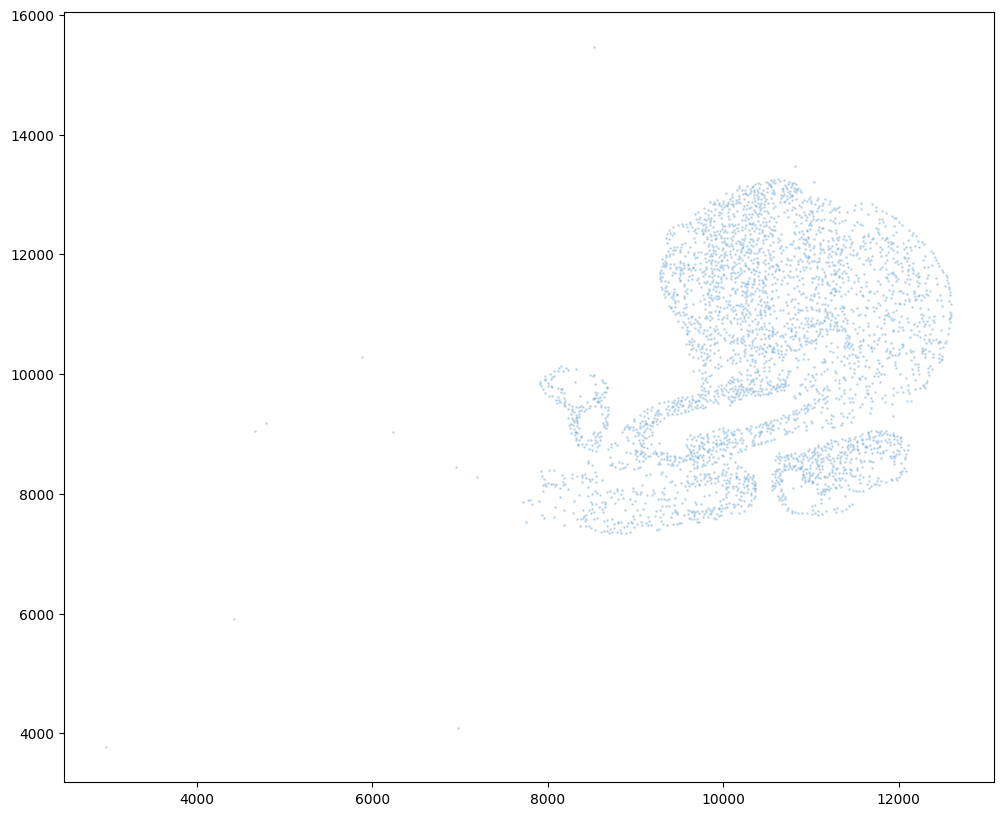

In [36]:
# get cell centroid coordinates
xI = np.array(df1['x'])
yI = np.array(df1['y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)

We will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 3605
3604 of 3605


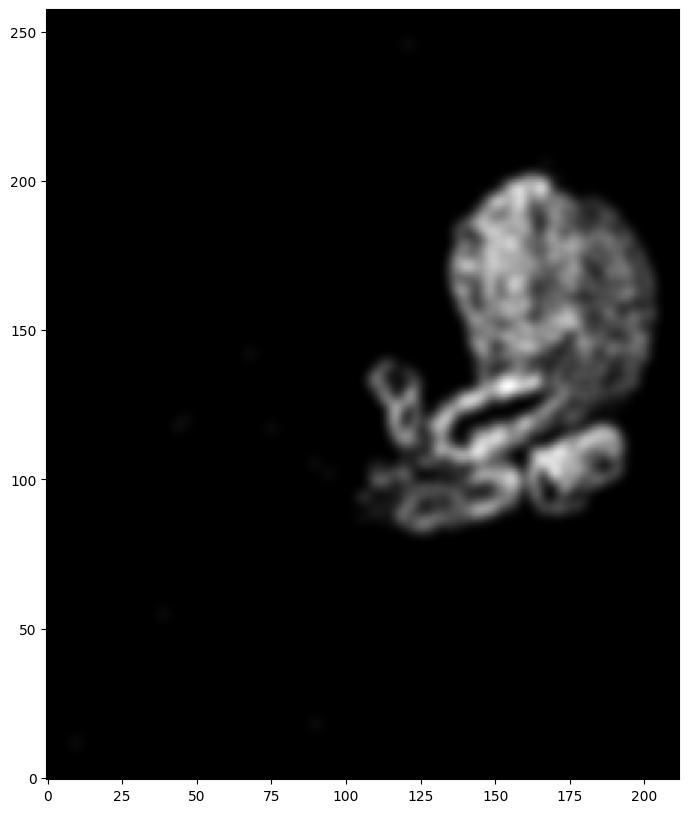

In [52]:
# rasterize at 100um resolution so image looks smooth
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=50)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Now, we can repeat this for the cell information from the second dataset.

In [37]:
# Single cell data 2
# read in data
fname = '../heart_data/4_CN73_C2.csv.gz'
df2 = pd.read_csv(fname, skiprows=[1]) # first row is data type
print(df2.head())

   Unnamed: 0            x             y   intensity  area  id    color   
0       27561  8411.487305  16145.589844  170.434784    52 NaN  #000000  \
1       27562  8572.000000  16053.444336  160.538467    24 NaN  #000000   
2       27563  5272.444336  15628.444336  167.750000    42 NaN  #000000   
3       27564  8577.416992  15178.750000  157.199997    32 NaN  #000000   
4       27565  6675.083496  15168.583008  161.800003    32 NaN  #000000   

  acronym  right.left  rostral.caudal  spot.id    image  
0     NaN  106.791747      705.649295      NaN  CN73_C2  
1     NaN  116.291280      700.149024      NaN  CN73_C2  
2     NaN  -92.698440      662.647180      NaN  CN73_C2  
3     NaN   98.792141      647.646442      NaN  CN73_C2  
4     NaN  -23.701834      640.646097     95.0  CN73_C2  


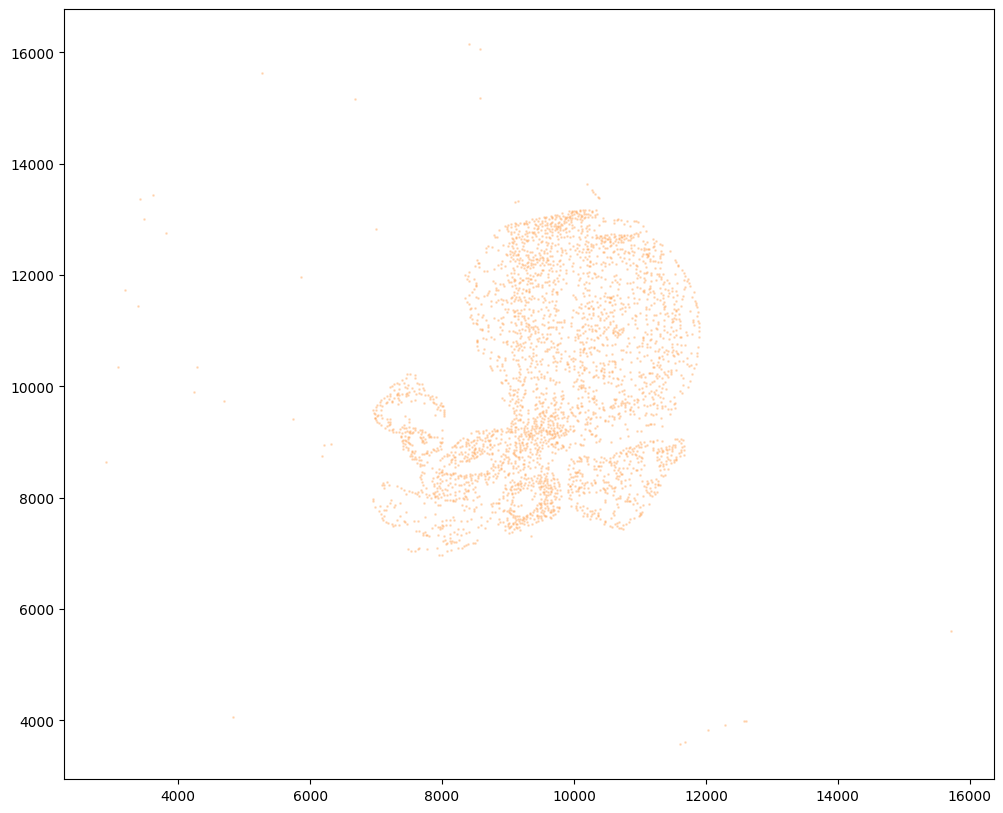

In [38]:
# get cell centroids
xJ = np.array(df2['x'])
yJ = np.array(df2['y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e')

0 of 3387
3386 of 3387


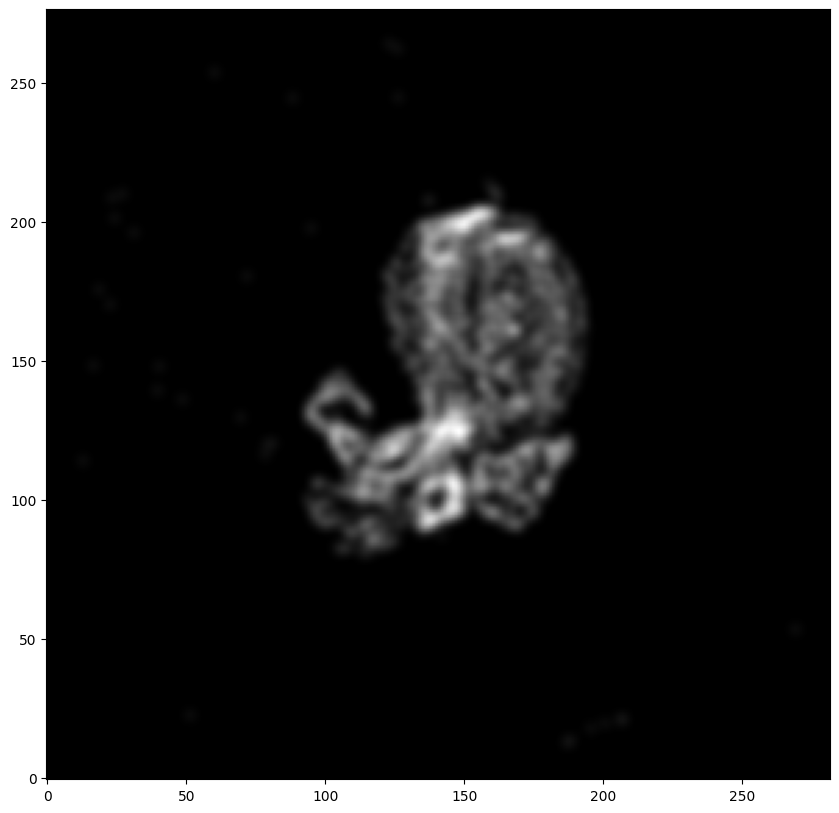

In [53]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=50)
ax = fig.axes[0]
ax.invert_yaxis()

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

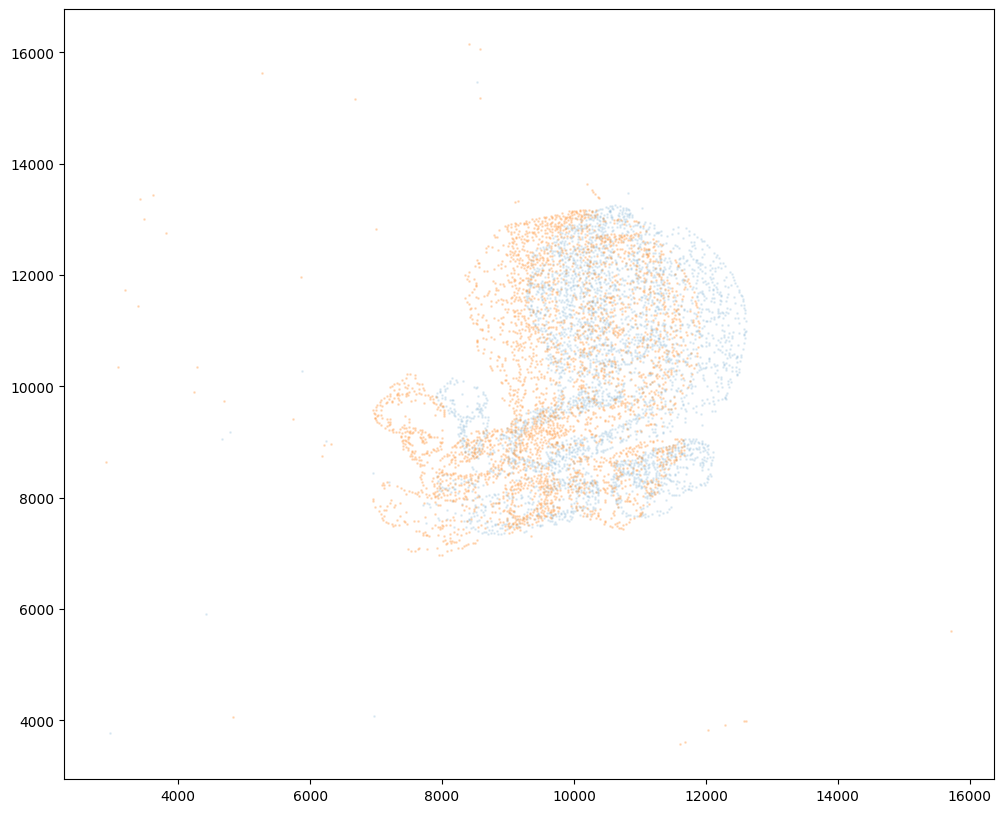

In [42]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1)
ax.scatter(xJ,yJ,s=1,alpha=0.2)


We can also plot the rasterized images next to each other.

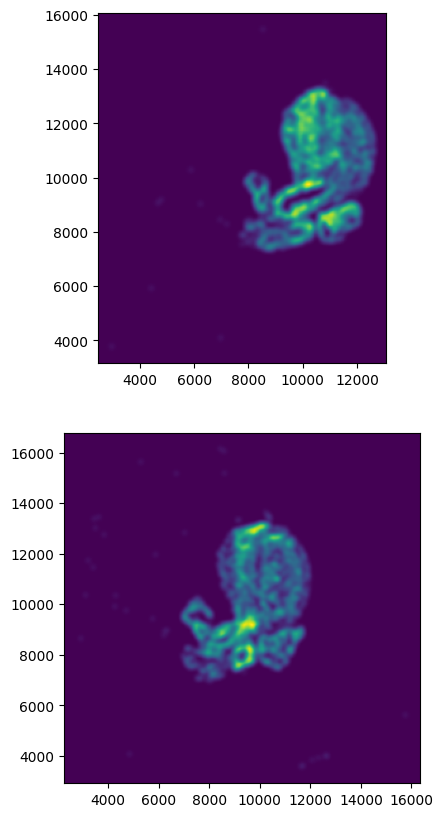

In [54]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(2,1)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

CPU times: user 4min 27s, sys: 47.1 s, total: 5min 14s
Wall time: 3min 57s


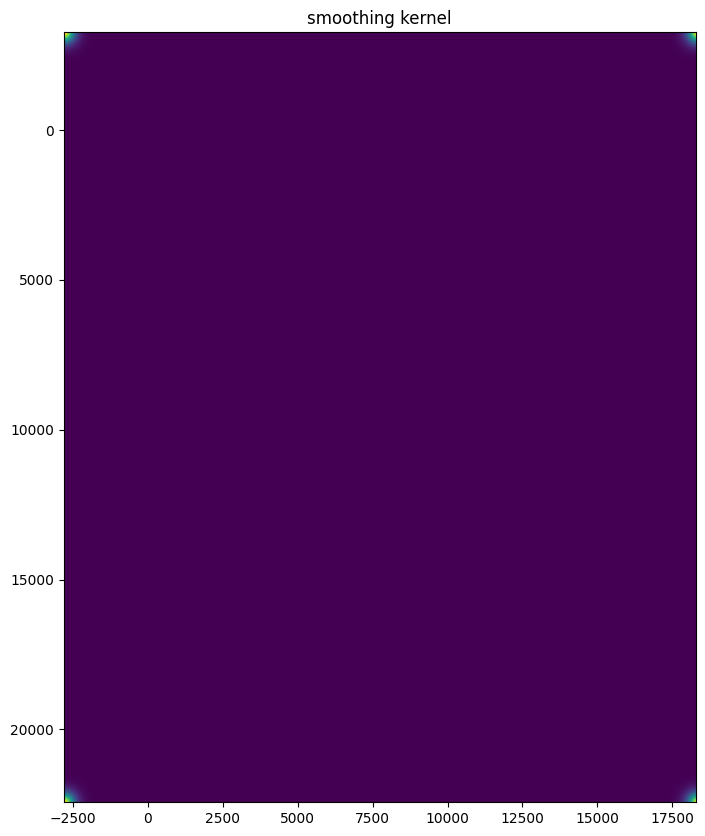

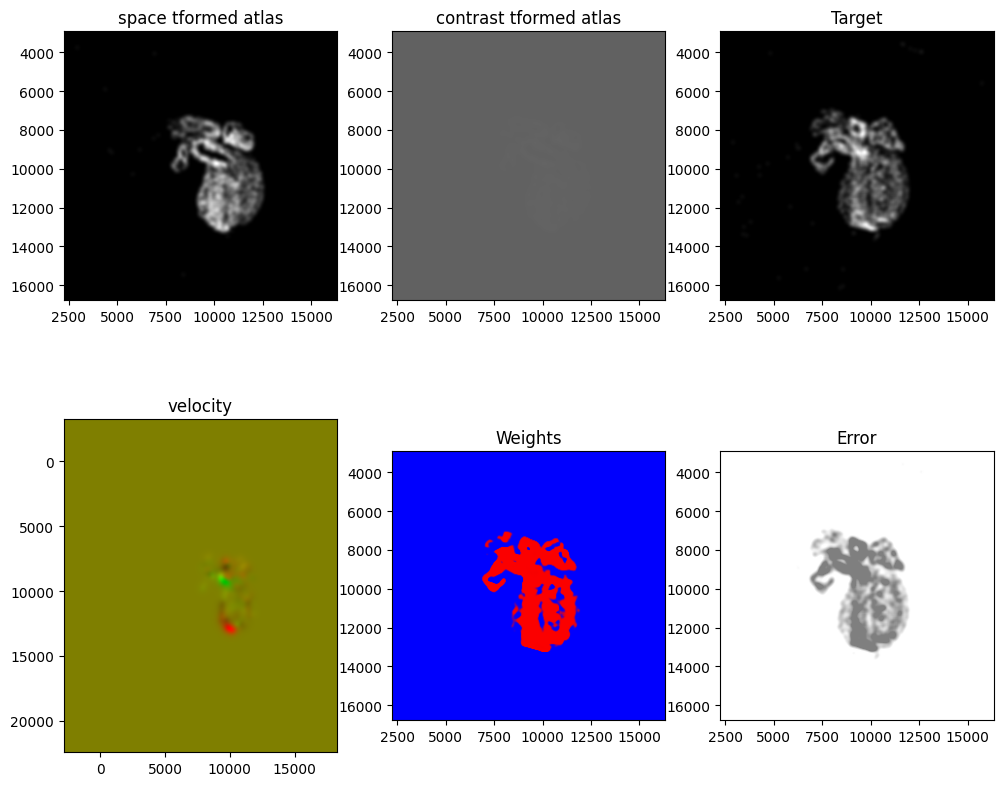

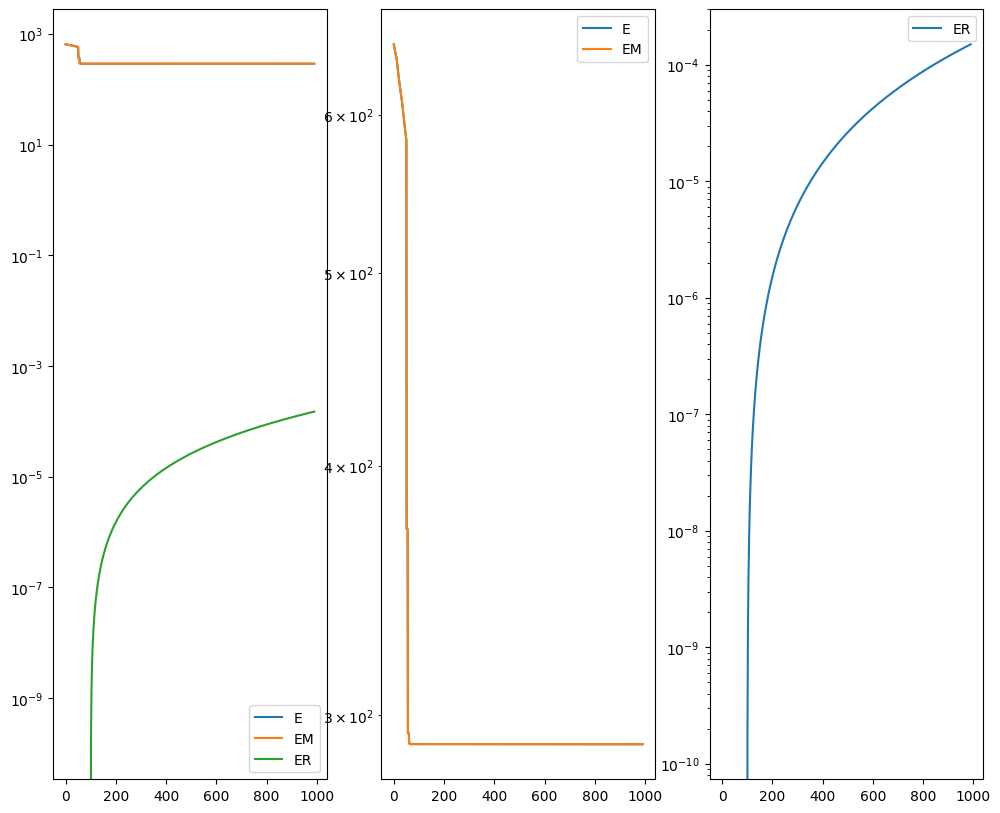

In [61]:
%%time 

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
          'niter':1000,
          'device':device,
          'diffeo_start':100,
          'a':100,
          'epV':1000,
          'sigmaB':0.1,
          'muB': torch.tensor([0,0,0]), # black is background in target
          }

Ifoo = np.vstack((I, I, I)) # make RGB instead of greyscale
Jfoo = np.vstack((J, J, J)) # make RGB instead of greyscale
out = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)

In [62]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

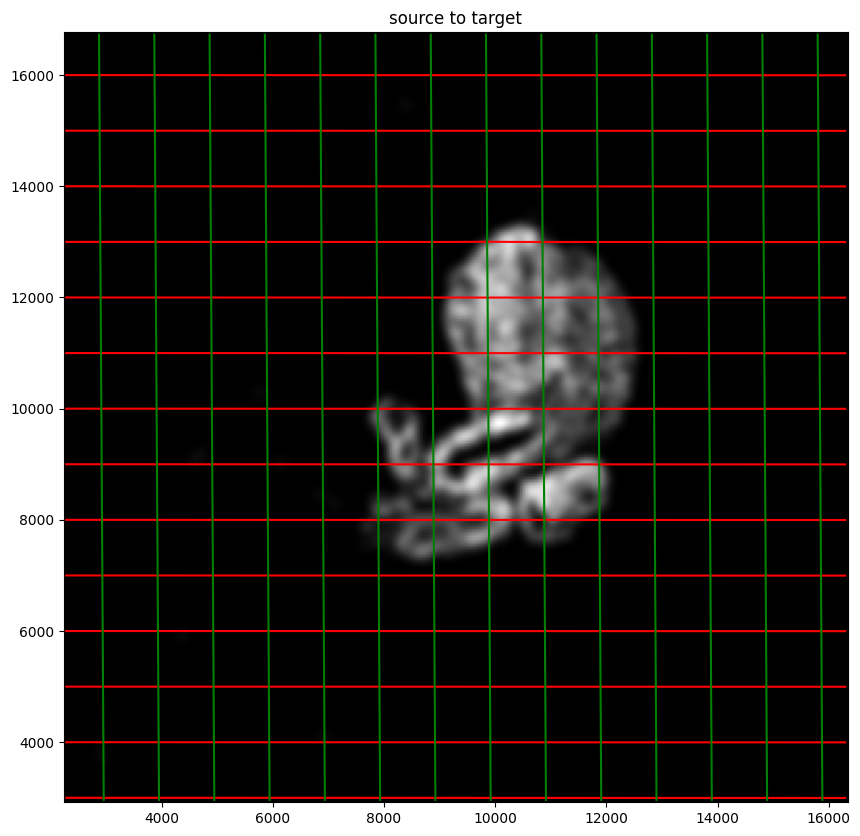

In [63]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],Ifoo,[YJ,XJ])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

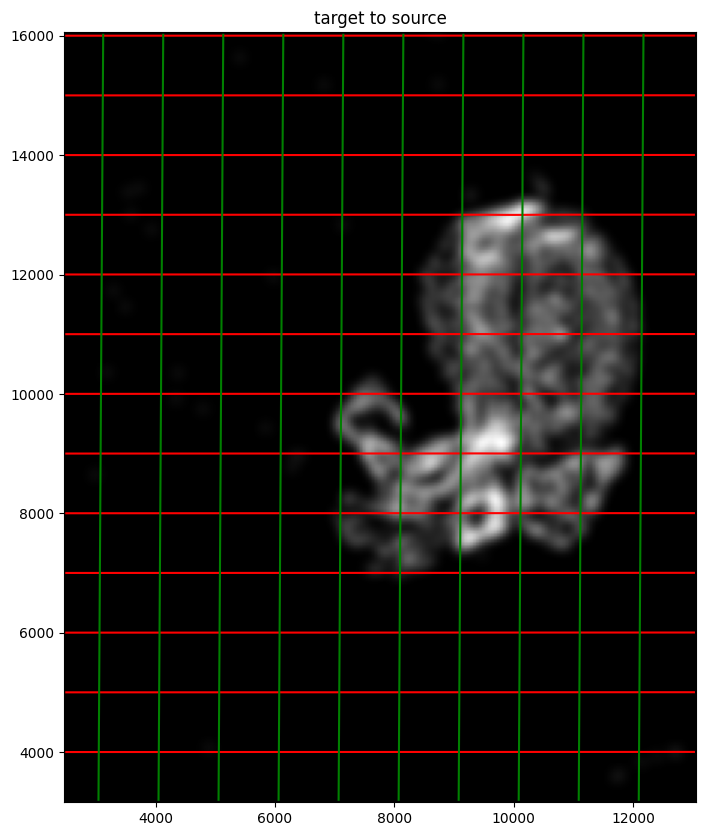

In [64]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],Jfoo,[YI,XI])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [65]:
# apply transform to original points
tpointsJ = STalign.transform_points_target_to_atlas(xv,v,A, np.stack([yJ, xJ], 1))

# just original points for visualizing later
tpointsI = np.stack([xI, yI]) 

And we can visualize the results.

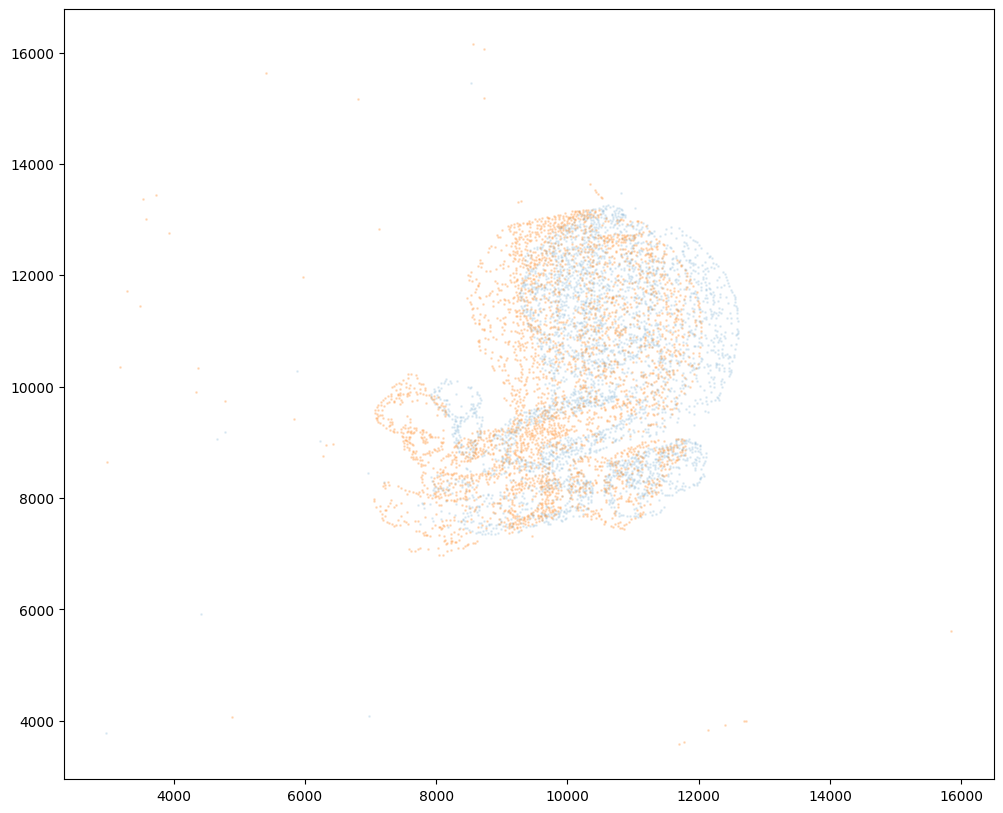

In [66]:
# plot results
fig,ax = plt.subplots()
ax.scatter(tpointsI[0,:],tpointsI[1,:],s=1,alpha=0.1) 
ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.2) # also needs to plot as y,x not x,y

In [ ]:
# write out results as needed